In [119]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords

In [120]:

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mahha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\mahha\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mahha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\mahha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mahha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [121]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
lemmatized_stop_words = [lemmatizer.lemmatize(w) for w in stop_words]
lemmatized_stop_words[:5]

['you', 'be', 'y', 'mustn', 'should']

In [122]:
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t.lower()) for t in nltk.word_tokenize(doc) if t.isalpha()]

In [123]:
spams = pd.read_table("SMSSmapCollection.txt", sep='\t')
spamsTrain, spamsTest = train_test_split(spams, train_size=0.7, random_state=1)
parseur1 = TfidfVectorizer()
parseur2 = TfidfVectorizer(stop_words='english')
parseur3 = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))
parseur_lemma = TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words=lemmatized_stop_words, token_pattern=None)

In [124]:
nan_rows = spamsTrain[spamsTrain.isna().any(axis=1)]
nan_rows

,classe,message


In [125]:
XTrain1 = parseur1.fit_transform(spamsTrain['message'])
XTest1 = parseur1.transform(spamsTest['message'])

In [126]:
XTrain2 = parseur2.fit_transform(spamsTrain['message'])
XTest2 = parseur2.transform(spamsTest['message'])

In [127]:
XTrain3 = parseur3.fit_transform(spamsTrain['message'])
XTest3 = parseur3.transform(spamsTest['message'])

In [128]:
XTrain_lemma = parseur_lemma.fit_transform(spamsTrain['message'])
XTest_lemma = parseur_lemma.transform(spamsTest['message'])

c:\Users\mahha\Desktop\coding\Text-Mining\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:411: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'might', 'must', 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


In [129]:
model1 = LogisticRegression()
model1.fit(XTrain1, spamsTrain['classe'])
model2 = LogisticRegression()
model2.fit(XTrain2, spamsTrain['classe'])
model3 = LogisticRegression()
model3.fit(XTrain3, spamsTrain['classe'])
model_lemma = LogisticRegression()
model_lemma.fit(XTrain_lemma, spamsTrain['classe'])

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [130]:
score1 = model1.score(XTrain1, spamsTrain['classe'])
score2 = model1.score(XTest1, spamsTest['classe'])
score3 = model2.score(XTest2, spamsTest['classe'])
score4 = model2.score(XTrain2, spamsTrain['classe'])
score5 = model3.score(XTest3, spamsTest['classe'])
score6 = model3.score(XTrain3, spamsTrain['classe'])
score_lemma_train = model_lemma.score(XTrain_lemma, spamsTrain['classe'])
score_lemma_test = model_lemma.score(XTest_lemma, spamsTest['classe'])

# print("Training Score:", score1)
# print("Testing Score:", score2)
# print("Training Score (model2):", score4)
# print("Testing Score (model2):", score3)
# print("Training Score (model3):", score6)
# print("Testing Score (model3):", score5)

data = {
    "Model": ["Model 1 (Default)", "Model 2 (Stopwords)", "Model 3 (Stopwords + N-grams)", "Model 4 (Lemmatized)"],
    "Training Score": [score1, score4, score6, score_lemma_train],
    "Testing Score": [score2, score3, score5, score_lemma_test]
}
results_df = pd.DataFrame(data)
results_df['Difference'] = results_df['Training Score'] - results_df['Testing Score']

results_df

,Model,Training Score,Testing Score,Difference
0,Model 1 (Default),0.983077,0.975478,0.007598
1,Model 2 (Stopwords),0.980000,0.974282,0.005718
2,Model 3 (Stopwords + N-grams),0.975385,0.973086,0.002298
3,Model 4 (Lemmatized),0.979487,0.965909,0.013578


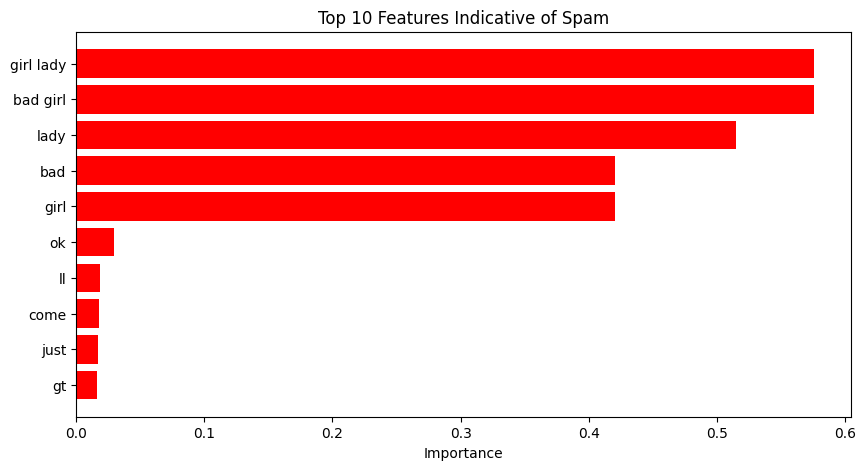

In [ ]:
# model 3 is the most interesting one with n-grams and stop word removal, let's look at the most important features for spam classification

words = parseur3.get_feature_names_out()
weights = model3.coef_[0]

feat_importance = pd.DataFrame({'feature': words, 'importance': weights})

top_spam = feat_importance.sort_values(by='importance', ascending=False).head(10)

plt.figure(figsize=(10, 5))
plt.barh(top_spam['feature'], top_spam['importance'], color='red')
plt.title('Top 10 Features Indicative of Spam')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.show()


In [133]:
def make_inference(messages, vectorizer, model):
    X_new = vectorizer.transform(messages)
    
    predictions = model.predict(X_new)
    probabilities = model.predict_proba(X_new)
    
    results = pd.DataFrame({
        'Message': messages,
        'Prediction': predictions,
        'Confidence': [max(p) for p in probabilities]
    })

    return results

In [142]:
messages = ["Hey, are we still meeting for couscous at 7?", 
            "CONGRATULATIONS! You've won a 1000 gift card. Click here to claim now!",
            "URGENT! Your mobile number has been selected for a prize!"]

make_inference(messages=messages, vectorizer=parseur3, model=model3)

,Message,Prediction,Confidence
0,"Hey, are we still meeting for couscous at 7?",ham,0.972404
1,CONGRATULATIONS! You've won a 1000 gift card. ...,spam,0.643774
2,URGENT! Your mobile number has been selected f...,spam,0.882500
